# **Credit Default Prediction Model Using Random Forest Algorithm**

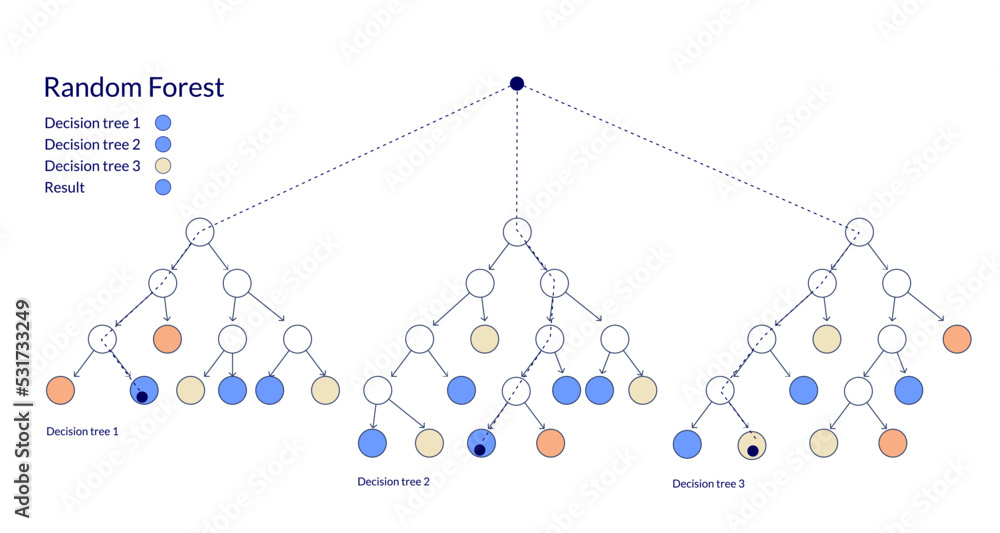
---


# **Background:**
This project makes use of the Random Forest machine learning algorithm in order to predict if a customer is likely to default on their credit loan based on some prerecorded data. We will go through the steps of preprocessing this data, fitting it to a model, and eventually training said model to make predictions.

 **What is a Random Forest?**

The Random Forest Algorithm is a type of Machine Learning algorithm that is made of multiple decision trees, and is used for classification and regression tasks. The Random Forest is an **ensemble** learning method, meaning it combines the prediction of multiple other models to produce a better overall prediction. In this case, the algorithm will be used in order to get accurate classifications of customers who may be more prone to default on loans.

**Dataset**

The dataset used in this project is the
Default of Credit Card Clients dataset available through the [UC Irvine Machine Learning Repository](https://archive.ics.uci.edu/dataset/350/default+of+credit+card+clients?utm_source=ibm_developer&utm_content=in_content_link&utm_id=tutorials_awb-random-forest-predict-credit-defaults).

# **The Project**
To begin, it is necessary to import a few important libraries. We will need **numpy** for some math calculations, **pandas** for data handling, **scikit-learn** for the Random Forest model and training, **seaborn** for visualizing the data, and **matplotlib** for plotting.

In [2]:
#Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#Import necessary utilities from scikit-learn
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier

Next we import the dataset and look at the first 5 rows in order to explore the data:

In [3]:
# Import the data set
df = pd.read_excel('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/UEym8G6lwphKjuhkLgkXAg/default%20of%20credit%20card%20clients.xls', header=1)

In [4]:
# Explore the first five rows of the data set
df.head(5)

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


We can rename the "default payment next month" column to just "DEFAULT" for simplicity. We can also get rid of the ID column since it doesn't tell us much.

In [5]:
# Rename the columns
df.rename({'default payment next month': 'DEFAULT'}, axis='columns', inplace=True)

#Remove the ID column as it is not informative
df.drop('ID', axis=1, inplace=True)
df.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


Now we check the data for any missing or Null values:

In [6]:
# Check dimensions for invalid values
print(f"SEX values include: {df['SEX'].unique()}")
print(f"MARRIAGE values include: {df['MARRIAGE'].unique()}")
print(f"EDUCATION values include: {df['EDUCATION'].unique()}")

# Count missing or null values
print(f"Number of missing values in SEX: {len(df[pd.isnull(df.SEX)])}")
print(f"Number of missing values in MARRIAGE: {len(df[pd.isnull(df.MARRIAGE)])}")
print(f"Number of missing values in EDUCATION: {len(df[pd.isnull(df.EDUCATION)])}")
print(f"Number of missing values in AGE: {len(df[pd.isnull(df.AGE)])}")



SEX values include: [2 1]
MARRIAGE values include: [1 2 3 0]
EDUCATION values include: [2 1 3 5 4 6 0]
Number of missing values in SEX: 0
Number of missing values in MARRIAGE: 0
Number of missing values in EDUCATION: 0
Number of missing values in AGE: 0


While there are no missing values, there are some invalid ones. According to the data description, Marriage should be described with values 1-4, and Education should consist only of values 1-3.

In [7]:
# Count of invalid data in EDUCATION and MARRIAGE
invalid_count = len(df.loc[(df['EDUCATION'] == 0) | (df['MARRIAGE'] == 0)])
print(f"Number of invalid data points in EDUCATION or MARRIAGE: {invalid_count}")

Number of invalid data points in EDUCATION or MARRIAGE: 68


We make the assumption that a 0 is representative of a missing value, and that a 5 or 6 is representative of some further education status not mentioned. Our next step is to filter the dataset of all missing values (0 for Education or Marriage).

In [8]:
print(f"shape of data: {df.shape}")

#Filter the DataFrame
df_no_missing_data = df.loc[(df['EDUCATION'] != 0) & (df['MARRIAGE'] != 0)]
print(f"shape of no_missing_data: {df_no_missing_data.shape}")

shape of data: (30000, 24)
shape of no_missing_data: (29932, 24)


Next is the all important step of visualizing the data. We shall look at what the distribution is of people who have defaulted previously (1) and haven't (0).

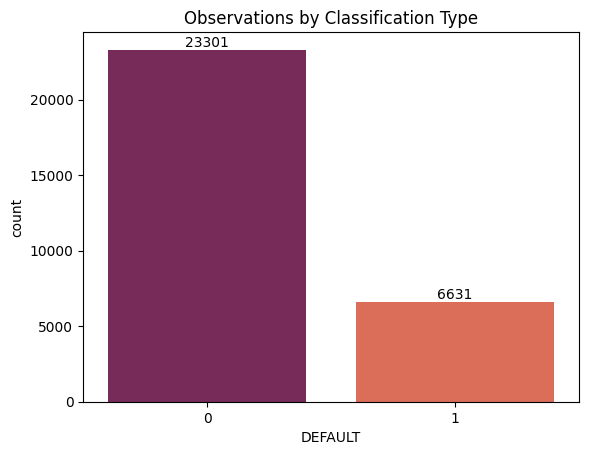

In [9]:
# Explore distribution of data set
# count plot on ouput variable
ax = sns.countplot(x = df_no_missing_data['DEFAULT'], palette = 'rocket', hue= df_no_missing_data['DEFAULT'], legend=False)

#add data labels
# ax.bar_label(ax.containers[0])
for container in ax.containers:
    ax.bar_label(container)

# add plot title
plt.title("Observations by Classification Type")

# show plot
plt.show()

Next we "downsample" the data. We will pick 1000 random examples of customers who defaulted and 1000 of those who did not. We will then combine these two sets to make one analysis dataset:

In [10]:
# split data
df_no_default = df_no_missing_data.loc[(df_no_missing_data['DEFAULT']==0)]
df_default = df_no_missing_data.loc[(df_no_missing_data['DEFAULT']==1)]

# downsample the data set
df_no_default_downsampled = resample(df_no_default, replace=False, n_samples=1000, random_state=0)
df_default_downsampled = resample(df_default, replace=False, n_samples=1000, random_state=0)

#check ouput
print(f"Length of df_no_default_downsampled: {len(df_no_default_downsampled)}")
print(f"Length of df_default_downsampled: {len(df_default_downsampled)}")

# merge the data sets
df_downsample = pd.concat([df_no_default_downsampled, df_default_downsampled ])
print(f"Shape of df_downsample: {df_downsample.shape}")

Length of df_no_default_downsampled: 1000
Length of df_default_downsampled: 1000
Shape of df_downsample: (2000, 24)


Another thing to do when checking/preprocessing data is to look at datapoints that may introduce bias towards certain groups. In order to reduce the possibility of our model being biased against certain people based on our data, we will drop certain independent variables from our dataset:

In [11]:
# isolate independent variables
X = df_downsample.drop(['DEFAULT','SEX', 'EDUCATION', 'MARRIAGE','AGE'], axis=1).copy()
print(f"Shape of X: {X.shape}")

Shape of X: (2000, 19)


Next we will one-hot encode the datasets we are keeping. One-hot encoding is the process of turning categorical values into numerical ones in order to represent them in our model.

In [12]:
# NOTE: 'PAY_1' is not shown in original data
X_encoded = pd.get_dummies(data=X, columns=['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6'])
print(f"Shape of X_encoded: {X_encoded.shape}")
X_encoded.head()

Shape of X_encoded: (2000, 70)


,LIMIT_BAL,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,...,PAY_5_7,PAY_6_-2,PAY_6_-1,PAY_6_0,PAY_6_2,PAY_6_3,PAY_6_4,PAY_6_5,PAY_6_6,PAY_6_7
2320,50000,390,918,19583,19593,19364,19893,918,19583,1000,...,False,False,False,True,False,False,False,False,False,False
2887,500000,24170,8051,77908,50297,43679,49749,8091,78192,65,...,False,False,False,True,False,False,False,False,False,False
9916,220000,4289,4637,1252,8069,18117,23176,1031,3077,7500,...,False,False,False,True,False,False,False,False,False,False
24070,80000,77901,79605,79207,0,0,0,3600,2407,0,...,False,True,False,False,False,False,False,False,False,False
16550,220000,38074,43083,47051,65321,83882,72812,6000,5000,20012,...,False,False,False,True,False,False,False,False,False,False


Next is just the process of splitting the data into testing and training sets:

In [13]:
# Split the data
y = df_downsample['DEFAULT'].copy()
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.3, random_state=0)

print(f'X_train.shape: {X_train.shape}')
print(f'X_test.shape: {X_test.shape}')
print(f'y_train.shape: {y_train.shape}')
print(f'y_test.shape: {y_test.shape}')

X_train.shape: (1400, 70)
X_test.shape: (600, 70)
y_train.shape: (1400,)
y_test.shape: (600,)


Now we actually create the model, train it, and test it on the data. We can plot the results on a Confusion Matrix for easier visualizations:

Accuracy: 63.83%
Percentage of correctly predicted Did Not Default: 66.88%
Percentage of correctly predicted Defaulted: 60.62%


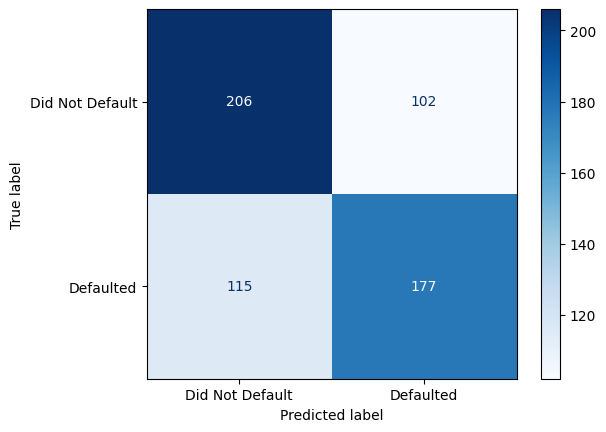

In [14]:
# apply RandomForestClassifier
rforest = RandomForestClassifier(max_depth=2, random_state=0)
rforest.fit(X_train, y_train)

#calculate overall accuracy
y_pred = rforest.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2%}')

class_names = ['Did Not Default', 'Defaulted']

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Calculate the percentage of correctly predicted instances for each class
for i, class_name in enumerate(class_names):
    correct_predictions = cm[i, i]
    total_predictions = cm[i, :].sum()
    class_accuracy = correct_predictions / total_predictions * 100
    print(f'Percentage of correctly predicted {class_name}: {class_accuracy:.2f}%')

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.show()

Finally, after seeing the prior results, we can now tune the hyperparameters. To do this, we can use the GridSearchCV funtion from scikit-learn. We can then use the best_params function to find the best parameters for the model:

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best parameters found: {'min_samples_split': 3, 'min_samples_leaf': 3, 'max_depth': 4}
Best estimator is: RandomForestClassifier(max_depth=4, min_samples_leaf=3, min_samples_split=3,
                       random_state=0)
Accuracy: 67.00%


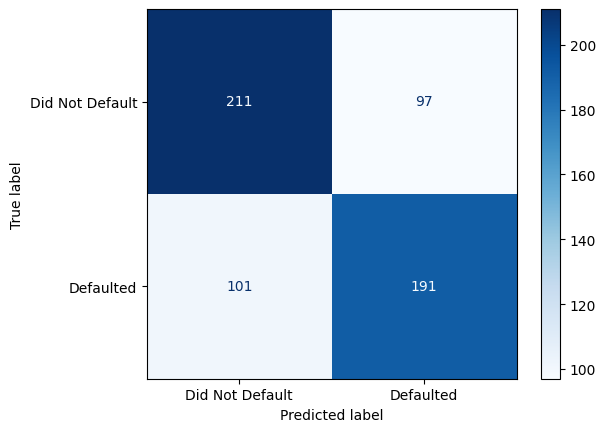

In [15]:
param_grid = {
    'max_depth':[3,4,5],
    'min_samples_split':[3,4,5],
    'min_samples_leaf':[3,4,5],
}

rf_random = RandomizedSearchCV(
    estimator=rforest,
    param_distributions=param_grid,
    n_iter=27,
    cv=3,
    random_state=0,
    verbose=1,
    n_jobs = -1,
)

# Fit the random search model
rf_random.fit(X_train, y_train)

# Output the best hyperparameters found
best_params = rf_random.best_params_
print(f'Best parameters found: {best_params}')
print(f'Best estimator is: {rf_random.best_estimator_}')

# Refit the model using the best hyperparameters
best_clf_rf = rf_random.best_estimator_

# In case you want to check all parameters currently in use
# print(f'Parameters currently in use: {best_clf_rf.get_params()}')

# Train the refitted model
best_clf_rf.fit(X_train, y_train)

# Calculate overall accuracy
y_pred = best_clf_rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2%}')

# Plot the confusion matrix
class_names = ['Did Not Default', 'Defaulted']
disp = ConfusionMatrixDisplay.from_estimator(
    best_clf_rf,
    X_test,
    y_test,
    display_labels=class_names,
    cmap=plt.cm.Blues,
)
plt.show()

In [16]:
print(classification_report(y_test, y_pred, target_names=["Did Not Default", "Defaulted"]))

                 precision    recall  f1-score   support

Did Not Default       0.68      0.69      0.68       308
      Defaulted       0.66      0.65      0.66       292

       accuracy                           0.67       600
      macro avg       0.67      0.67      0.67       600
   weighted avg       0.67      0.67      0.67       600

